<a href="https://colab.research.google.com/github/hanyG175/machine-learning/blob/main/Plant-Disease-Detection-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/datasets/crop-pest-and-disease-detection.zip -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Tomato leaf blight/leaf blight1302_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1303_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1304_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1305_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1306_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1307_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1308_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1309_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight130_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1310_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1311_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1312_.jpg  
  inflating: /content/dataset/Tomato leaf blight/leaf blight1313_.jpg  
  inflating: /

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random

In [ ]:
data_path = "dataset/"

img_size = (224, 224)  # Use a larger size for better feature extraction
batch_size = 32

In [ ]:
from PIL import Image

# Iterate through all files and remove corrupted ones
def remove_corrupted_images(path):
    corrupted_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify the image file integrity
            except (IOError, SyntaxError):
                print(f"Corrupted file detected and deleted: {file_path}")
                corrupted_files.append(file_path)
                os.remove(file_path)

remove_corrupted_images(data_path)


In [ ]:
def is_valid_image(file_path):
        """
        Validate if an image is readable and not corrupted
        """
        try:
            with Image.open(file_path) as img:
                img.verify()
                # Additional check to ensure image can be loaded
                test_img = Image.open(file_path)
                test_img.load()
            return True
        except Exception as e:
            print(f"Corrupted image detected: {file_path}")
            print(f"Error: {e}")
            return False

def clean_dataset(dataset_path):
    """
    Thoroughly clean dataset by removing corrupted images
    """
    total_images = 0
    removed_images = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                file_path = os.path.join(root, file)
                total_images += 1

                # Try reading image, remove if corrupted
                if not is_valid_image(file_path):
                    os.remove(file_path)
                    removed_images += 1

    print(f"Total images scanned: {total_images}")
    print(f"Corrupted images removed: {removed_images}")

clean_dataset(data_path)

Corrupted image detected: dataset/Maize streak virus/streak virus554_.jpg
Error: broken data stream when reading image file
Corrupted image detected: dataset/Maize streak virus/streak virus626_.jpg
Error: broken data stream when reading image file
Corrupted image detected: dataset/Maize streak virus/streak virus485_.jpg
Error: broken data stream when reading image file
Corrupted image detected: dataset/Maize streak virus/streak virus118_.jpg
Error: broken data stream when reading image file
Corrupted image detected: dataset/Maize streak virus/streak virus997_.jpg
Error: broken data stream when reading image file
Corrupted image detected: dataset/Maize streak virus/streak virus773_.jpg
Error: broken data stream when reading image file
Corrupted image detected: dataset/Maize streak virus/streak virus421_.jpg
Error: broken data stream when reading image file
Corrupted image detected: dataset/Tomato healthy/healthy442_.jpg
Error: broken data stream when reading image file
Corrupted image d

In [ ]:
test_data_path = "test_data_path"
# List all files and directories
classes = os.listdir(data_path)

# Split data
for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    images = os.listdir(class_path)

    train_val, test = train_test_split(images, test_size=0.15, random_state=42)

    # Create directories for test data
    test_class_path = os.path.join(test_data_path, class_name)
    os.makedirs(test_class_path, exist_ok=True)

    # Move test images
    for image in test:
        shutil.move(os.path.join(class_path, image), os.path.join(test_class_path, image))

In [ ]:
import os
from collections import Counter
class_counts = Counter()
for class_dir in os.listdir(data_path):
    class_path = os.path.join(data_path, class_dir)
    if os.path.isdir(class_path):
        class_counts[class_dir] = len(os.listdir(class_path))

print("Class Distribution:")
for cls, count in sorted(class_counts.items(),key= lambda x: x[1], reverse=True):
    print(f"{cls}: {count}")


Class Distribution:
Tomato septoria leaf spot: 2331
Cassava bacterial blight: 2221
Cashew anthracnose: 1469
Cashew red rust: 1429
Cassava brown spot: 1258
Cashew leaf miner: 1171
Cashew healthy: 1162
Tomato leaf blight: 1094
Maize leaf spot: 1053
Cassava mosaic: 1024
Cassava healthy: 1014
Cassava green mite: 862
Maize leaf blight: 841
Maize streak virus: 820
Maize leaf beetle: 793
Tomato verticulium wilt: 656
Maize grasshoper: 572
Tomato leaf curl: 434
Tomato healthy: 396
Cashew gumosis: 333
Maize fall armyworm: 242
Maize healthy: 173


In [ ]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copy2
import numpy as np
from pathlib import Path
import logging
import sys
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
import multiprocessing
import queue
from tqdm import tqdm
import psutil

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

class DatasetBalancer:
    def __init__(self, data_path, balanced_path, batch_size=32, max_workers=None):
        """
        Initialize the dataset balancer with configurable parameters.

        Args:
            data_path (str): Source dataset path
            balanced_path (str): Output balanced dataset path
            batch_size (int): Batch size for processing images
            max_workers (int): Maximum number of worker threads
        """
        self.data_path = Path(data_path)
        self.balanced_path = Path(balanced_path)
        self.batch_size = batch_size
        self.max_workers = max_workers or min(32, (os.cpu_count() or 1) * 2)

        # Configure memory limits
        self.memory_limit = int(psutil.virtual_memory().total * 0.7)  # Use up to 70% of available RAM
        self.data_gen = self._create_data_generator()

    @staticmethod
    def _create_data_generator():
        """Create and return optimized ImageDataGenerator."""
        return ImageDataGenerator(
            rescale=1.0 / 255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.2,
            fill_mode='nearest'
        )

    def _process_image_batch(self, image_files, save_dir, augment=False):
        """Process a batch of images in parallel."""
        try:
            for img_file in image_files:
                if augment:
                    self._augment_and_save_image(img_file, save_dir)
                else:
                    copy2(str(img_file), str(save_dir))
            return len(image_files)
        except Exception as e:
            logging.error(f"Error processing batch: {str(e)}")
            return 0

    def _augment_and_save_image(self, source_img, save_dir):
        """Augment and save a single image with optimized memory handling."""
        try:
            img = tf.keras.preprocessing.image.load_img(str(source_img))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, 0)

            batch = next(self.data_gen.flow(
                img_array,
                batch_size=1,
                save_to_dir=str(save_dir),
                save_prefix=f'aug_{source_img.stem}',
                save_format='jpg'
            ))

            # Clear memory
            del img, img_array, batch
            tf.keras.backend.clear_session()

        except Exception as e:
            logging.error(f"Error augmenting {source_img}: {str(e)}")

    def _process_class(self, class_name, count, target_count):
        """Process a single class with optimized batch processing."""
        try:
            class_dir = self.data_path / class_name
            save_dir = self.balanced_path / class_name
            save_dir.mkdir(exist_ok=True, parents=True)

            # Clear existing files
            for file in save_dir.glob('*'):
                file.unlink()

            images = list(class_dir.glob('*'))

            if count < target_count:
                # Copy original images
                self._batch_process_images(images, save_dir, False)

                # Calculate remaining augmentations needed
                remaining = target_count - count
                source_images = [random.choice(images) for _ in range(remaining)]
                self._batch_process_images(source_images, save_dir, True)

            elif count > target_count:
                selected_images = random.sample(images, target_count)
                self._batch_process_images(selected_images, save_dir, False)

            else:  # count == target_count
                self._batch_process_images(images, save_dir, False)

            return len(list(save_dir.glob('*')))

        except Exception as e:
            logging.error(f"Error processing class {class_name}: {str(e)}")
            return 0

    def _batch_process_images(self, images, save_dir, augment=False):
        """Process images in optimized batches using thread pool."""
        batches = [images[i:i + self.batch_size] for i in range(0, len(images), self.batch_size)]

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            process_batch = partial(self._process_image_batch, save_dir=save_dir, augment=augment)
            futures = [executor.submit(process_batch, batch) for batch in batches]

            with tqdm(total=len(images), desc=f"Processing {'augmented' if augment else 'original'} images") as pbar:
                for future in as_completed(futures):
                    pbar.update(future.result())

    def balance_dataset(self, target_count=None):
        """
        Balance the dataset with optimized parallel processing.

        Args:
            target_count (int, optional): Target sample size per class
        """
        try:
            # Validate directories
            if not self.data_path.exists():
                raise ValueError(f"Source data path does not exist: {self.data_path}")
            os.makedirs(self.balanced_path, exist_ok=True)

            # Get class distribution
            class_counts = {
                class_dir.name: len(list(class_dir.glob('*')))
                for class_dir in self.data_path.iterdir()
                if class_dir.is_dir()
            }

            target_count = target_count or max(class_counts.values())
            logging.info(f"Balancing dataset to {target_count} samples per class")

            # Process classes in parallel
            with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                futures = {
                    executor.submit(self._process_class, class_name, count, target_count): class_name
                    for class_name, count in class_counts.items()
                }

                results = {}
                for future in tqdm(as_completed(futures), total=len(futures), desc="Processing classes"):
                    class_name = futures[future]
                    try:
                        results[class_name] = future.result()
                    except Exception as e:
                        logging.error(f"Error processing class {class_name}: {str(e)}")
                        results[class_name] = 0

            # Verify final distribution
            logging.info("Final class distribution:")
            for class_name, count in results.items():
                logging.info(f"{class_name}: {count}")
                if count != target_count:
                    logging.warning(f"Class {class_name} ended with {count} samples instead of {target_count}")

            return results

        except Exception as e:
            logging.error(f"Error during dataset balancing: {str(e)}")
            raise

if __name__ == "__main__":
    data_path = "dataset"
    balanced_path = "balanced_dataset"
    balancer = DatasetBalancer(data_path, balanced_path)
    balancer.balance_dataset()

Processing original images:   0%|          | 0/396 [00:00<?, ?it/s]

Processing original images:   0%|          | 0/2331 [00:00<?, ?it/s]


Processing original images:   0%|          | 0/793 [00:00<?, ?it/s]



Processing original images:  16%|█▌        | 64/396 [00:00<00:00, 588.21it/s]

Processing original images:   5%|▌         | 128/2331 [00:00<00:01, 1210.58it/s]


Processing original images:   8%|▊         | 64/793 [00:00<00:01, 492.20it/s]



Processing original images:  40%|████      | 160/396 [00:00<00:00, 743.26it/s]

Processing original images:  11%|█         | 256/2331 [00:00<00:01, 1073.01it/s]


Processing original images:  73%|███████▎  | 288/396 [00:00<00:00, 900.90it/s]



Processing original images:  31%|███       | 256/820 [00:00<00:00, 816.76it/s]

Processing original images: 100%|██████████| 396/396 [00:00<00:00, 865.71it/s]



Processing original images:  36%|███▋      | 288/793 [00:00<00:00, 738.56it/s]



Processing original images:  43%|████▎     | 352/820 [00:

In [ ]:
balanced_class_counts = {}
for class_dir in os.listdir(balanced_path):
    class_path = os.path.join(balanced_path, class_dir)
    if os.path.isdir(class_path):
        balanced_class_counts[class_dir] = len(os.listdir(class_path))

print("Balanced Class Distribution:", balanced_class_counts)

Balanced Class Distribution: {'Tomato septoria leaf spot': 2331, 'Maize streak virus': 2331, 'Tomato healthy': 2331, 'Maize leaf beetle': 2331, 'Cashew anthracnose': 2331, 'Maize leaf blight': 2331, 'Cassava bacterial blight': 2331, 'Cassava healthy': 2331, 'Tomato leaf blight': 2331, 'Cashew healthy': 2331, 'Cassava green mite': 2331, 'Cashew leaf miner': 2331, 'Cassava brown spot': 2331, 'Maize leaf spot': 2331, 'Cassava mosaic': 2331, 'Maize fall armyworm': 2331, 'Maize healthy': 2329, 'Cashew gumosis': 2331, 'Maize grasshoper': 2331, 'Tomato verticulium wilt': 2331, 'Cashew red rust': 2331, 'Tomato leaf curl': 2331}


In [ ]:
# Configuration
DATA_DIR = "balanced_dataset"
IMG_HEIGHT = 128  # Instead of 224
IMG_WIDTH = 128   # Instead of 224
BATCH_SIZE = 64
EPOCHS = 10
VALIDATION_SPLIT = 0.2

In [ ]:
# Create data generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=10,     # Reduced from 20
    width_shift_range=0.1, # Reduced from 0.2
    height_shift_range=0.1, # Reduced from 0.2
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Load training data
train_data = train_generator.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
val_data = train_generator.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 41029 images belonging to 22 classes.
Found 10251 images belonging to 22 classes.


In [ ]:
# Get number of classes
num_classes = len(train_data.class_indices)
class_names = list(train_data.class_indices.keys())
print(f"Found {num_classes} classes: {class_names}")

Found 22 classes: ['Cashew anthracnose', 'Cashew gumosis', 'Cashew healthy', 'Cashew leaf miner', 'Cashew red rust', 'Cassava bacterial blight', 'Cassava brown spot', 'Cassava green mite', 'Cassava healthy', 'Cassava mosaic', 'Maize fall armyworm', 'Maize grasshoper', 'Maize healthy', 'Maize leaf beetle', 'Maize leaf blight', 'Maize leaf spot', 'Maize streak virus', 'Tomato healthy', 'Tomato leaf blight', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Tomato verticulium wilt']


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze base model initially

model = Sequential([
    # First Convolutional Block
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Second block
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Third block
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │           5,654 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,223,798 (16.11 MB)

 Trainable params: 4,223,798 (16.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set up callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# steps_per_epoch = math.ceil(train_generator.samples / batch_size)
# validation_steps = math.ceil(validation_generator.samples / batch_size)

# Train the model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks
)

# Create directory for saving results
Path('evaluation_results').mkdir(exist_ok=True)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


642/642 ━━━━━━━━━━━━━━━━━━━━ 277s 418ms/step - accuracy: 0.2079 - loss: 2.5585 - val_accuracy: 0.3300 - val_loss: 2.1012 - learning_rate: 0.0010
Epoch 2/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 264s 409ms/step - accuracy: 0.4144 - loss: 1.8173 - val_accuracy: 0.3999 - val_loss: 1.9044 - learning_rate: 0.0010
Epoch 3/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 264s 408ms/step - accuracy: 0.4762 - loss: 1.6020 - val_accuracy: 0.4645 - val_loss: 1.6713 - learning_rate: 0.0010
Epoch 4/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 262s 405ms/step - accuracy: 0.5226 - loss: 1.4429 - val_accuracy: 0.5179 - val_loss: 1.5185 - learning_rate: 0.0010
Epoch 5/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 324s 410ms/step - accuracy: 0.5592 - loss: 1.3255 - val_accuracy: 0.5153 - val_loss: 1.5066 - learning_rate: 0.0010
Epoch 6/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 320s 405ms/step - accuracy: 0.5805 - loss: 1.2544 - val_accuracy: 0.5550 - val_loss: 1.3838 - learning_rate: 0.0010
Epoch 7/10
642/642 ━━━━━━━━━━━━━━━━━━━━ 267s 412ms/step - accuracy: 0.6018 

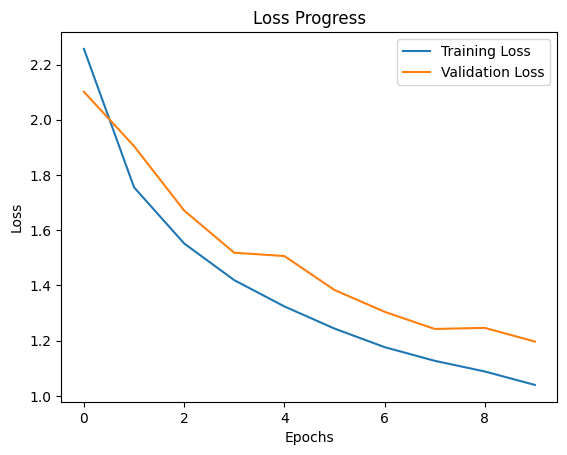

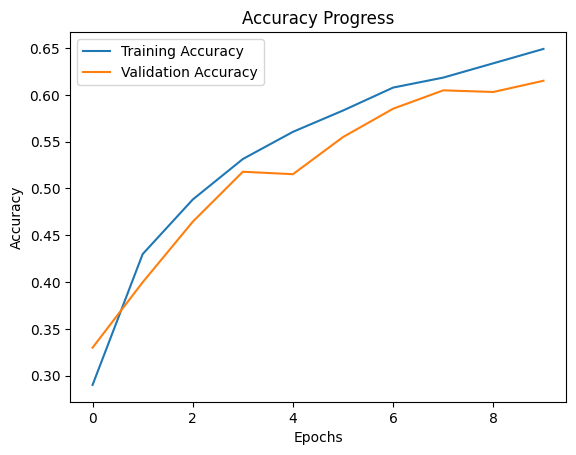

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions for confusion matrix
val_predictions = model.predict(val_data)
y_pred = np.argmax(val_predictions, axis=1)
y_true = val_data.classes

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('evaluation_results/confusion_matrix.png')
plt.close()

161/161 ━━━━━━━━━━━━━━━━━━━━ 51s 311ms/step


In [ ]:
# Generate and save classification report
report = classification_report(y_true, y_pred, target_names=class_names)
with open('evaluation_results/classification_report.txt', 'w') as f:
    f.write(report)
print(f"\nClassification Report:\n{report}")


Classification Report:
                           precision    recall  f1-score   support

       Cashew anthracnose       0.76      0.33      0.46       466
           Cashew gumosis       0.94      0.94      0.94       466
           Cashew healthy       0.82      0.53      0.64       466
        Cashew leaf miner       0.61      0.49      0.54       466
          Cashew red rust       0.92      0.74      0.82       466
 Cassava bacterial blight       0.40      0.54      0.46       466
       Cassava brown spot       0.56      0.76      0.65       466
       Cassava green mite       0.51      0.80      0.62       466
          Cassava healthy       0.81      0.77      0.79       466
           Cassava mosaic       0.57      0.70      0.63       466
      Maize fall armyworm       0.68      0.54      0.60       466
         Maize grasshoper       0.74      0.83      0.79       466
            Maize healthy       0.58      0.89      0.70       465
        Maize leaf beetle       0.73 

In [ ]:
# Check the model's performance on unseen data (test set).
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',

)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 3778 images belonging to 22 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.6567 - loss: 1.0383
Test Accuracy: 65.27%


In [ ]:
model.save('plant_disease_model.h5')